In [11]:
import dill
import numpy as np
import scanner_interpretation as sc
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from corner import corner, overplot_points
import astropy.visualization as vis
rd = sc.Reduced("pkl_jugs/n4/reduced_complete.pkl")
rd_old = sc.Reduced("pkl_jugs/n3/reduced_complete.pkl")
# rd_old.reduced["BERNOULLI_SIGMA"] = sc.n_sigmas(rd_old.reduced["BERNOULLI_P"])


def get_leftover(redu) -> np.ndarray:

# pval_0_mask = redu.reduced["LAMBDA_RATIO_SIGNIFICANCE"]==0.
    bernP_nan_mask = np.isnan(redu.reduced["BERNOULLI_P"])
    expP_nan_mask = np.isnan(redu.reduced["EXP_CORRECTED_P"])
    bernP_finite_mask = np.isfinite(redu.reduced["BERNOULLI_P"])
    expP_finite_mask = np.isfinite(redu.reduced["EXP_CORRECTED_P"])
    bernP_0_mask = redu.reduced["BERNOULLI_P"] == 0
    expP_0_mask = redu.reduced["EXP_CORRECTED_P"] == 0

    sanebern = ~bernP_nan_mask * bernP_finite_mask * ~bernP_0_mask
    saneexp = ~expP_nan_mask * expP_finite_mask * ~expP_0_mask

    leftover = sanebern * saneexp
    return leftover

l_n4 = get_leftover(rd)
l_n3 = get_leftover(rd_old)

rd.addFlux()
rd_old.addFlux()

100%|██████████| 26329/26329 [00:00<00:00, 180039.37it/s]


Flux

In [2]:
rd.reduced.colnames

['Nmax',
 'OBS_ID',
 'ID',
 'RA',
 'DEC',
 'TIME',
 'ENERGY',
 'dt',
 'da',
 'MEDIAN_RA',
 'MEDIAN_DEC',
 'SkyCoord',
 'MEDIAN_GLAT',
 'MEDIAN_GLON',
 'TEVCAT_SOURCE_NAME',
 'TEVCAT_SOURCE_TYPE',
 'TEVCAT_DISTANCES_DEG',
 'TEVCAT_FLUX_CRAB',
 'DS_INDEX',
 'ANGULAR_MEASURE_DEG',
 'ALT_PNT',
 'PNT_SOURCE',
 'PNT_DISTANCE',
 'BKG_DT_LAMBDA',
 'BKG_PHOTONS',
 'MPLET_DT_LAMBDA',
 'LAMBDA_RATIO_SIGNIFICANCE',
 'BELL_FRACTION',
 'EXP_CORRECTED_P',
 'BERNOULLI_P',
 'BERNOULLI_SIGMA',
 'FLUX_ERGS_PER_SECOND_CM2']

In [ ]:
from astropy.table import Table
from scipy.stats import spearmanr,pearsonr

def get_correlation(tab: Table,var_names:list[str],corrfn = pearsonr):
    if len(var_names) != 2:
        raise ValueError(f"Please give 2 variables instead of {len(var_names)}")
    return corrfn(tab[var_names[0]],tab[var_names[1]])


In [ ]:
get_correlation(rd.reduced[l_n4],["FLUX_ERGS_PER_SECOND_CM2","BERNOULLI_SIGMA"],spearmanr)

In [13]:
rd.reduced["LOG_FLUX_ERGS_PER_SECOND_CM2"] = np.log10(rd.reduced["FLUX_ERGS_PER_SECOND_CM2"])
rd.reduced["LAMBDA_RATIO"] = rd.reduced["BKG_DT_LAMBDA"] / rd.reduced["BKG_PHOTONS"]
rd.reduced["LOG_LAMBDA_RATIO"] = np.log10(rd.reduced["LAMBDA_RATIO"])
rd.reduced["LOG_BELL_FRAC"] = np.log10(rd.reduced["BELL_FRACTION"])

/tmp/ipykernel_175699/2549402804.py:2: RuntimeWarning: invalid value encountered in divide
  rd.reduced["LAMBDA_RATIO"] = rd.reduced["BKG_DT_LAMBDA"] / rd.reduced["BKG_PHOTONS"]


(array([ 48.,  43.,  39.,  49.,  32.,  43.,  32.,  34.,  36.,  47., 201.]),
 array([0.63214243, 0.66558403, 0.69902563, 0.73246722, 0.76590882,
        0.79935042, 0.83279202, 0.86623361, 0.89967521, 0.93311681,
        0.9665584 , 1.        ]),
 <BarContainer object of 11 artists>)

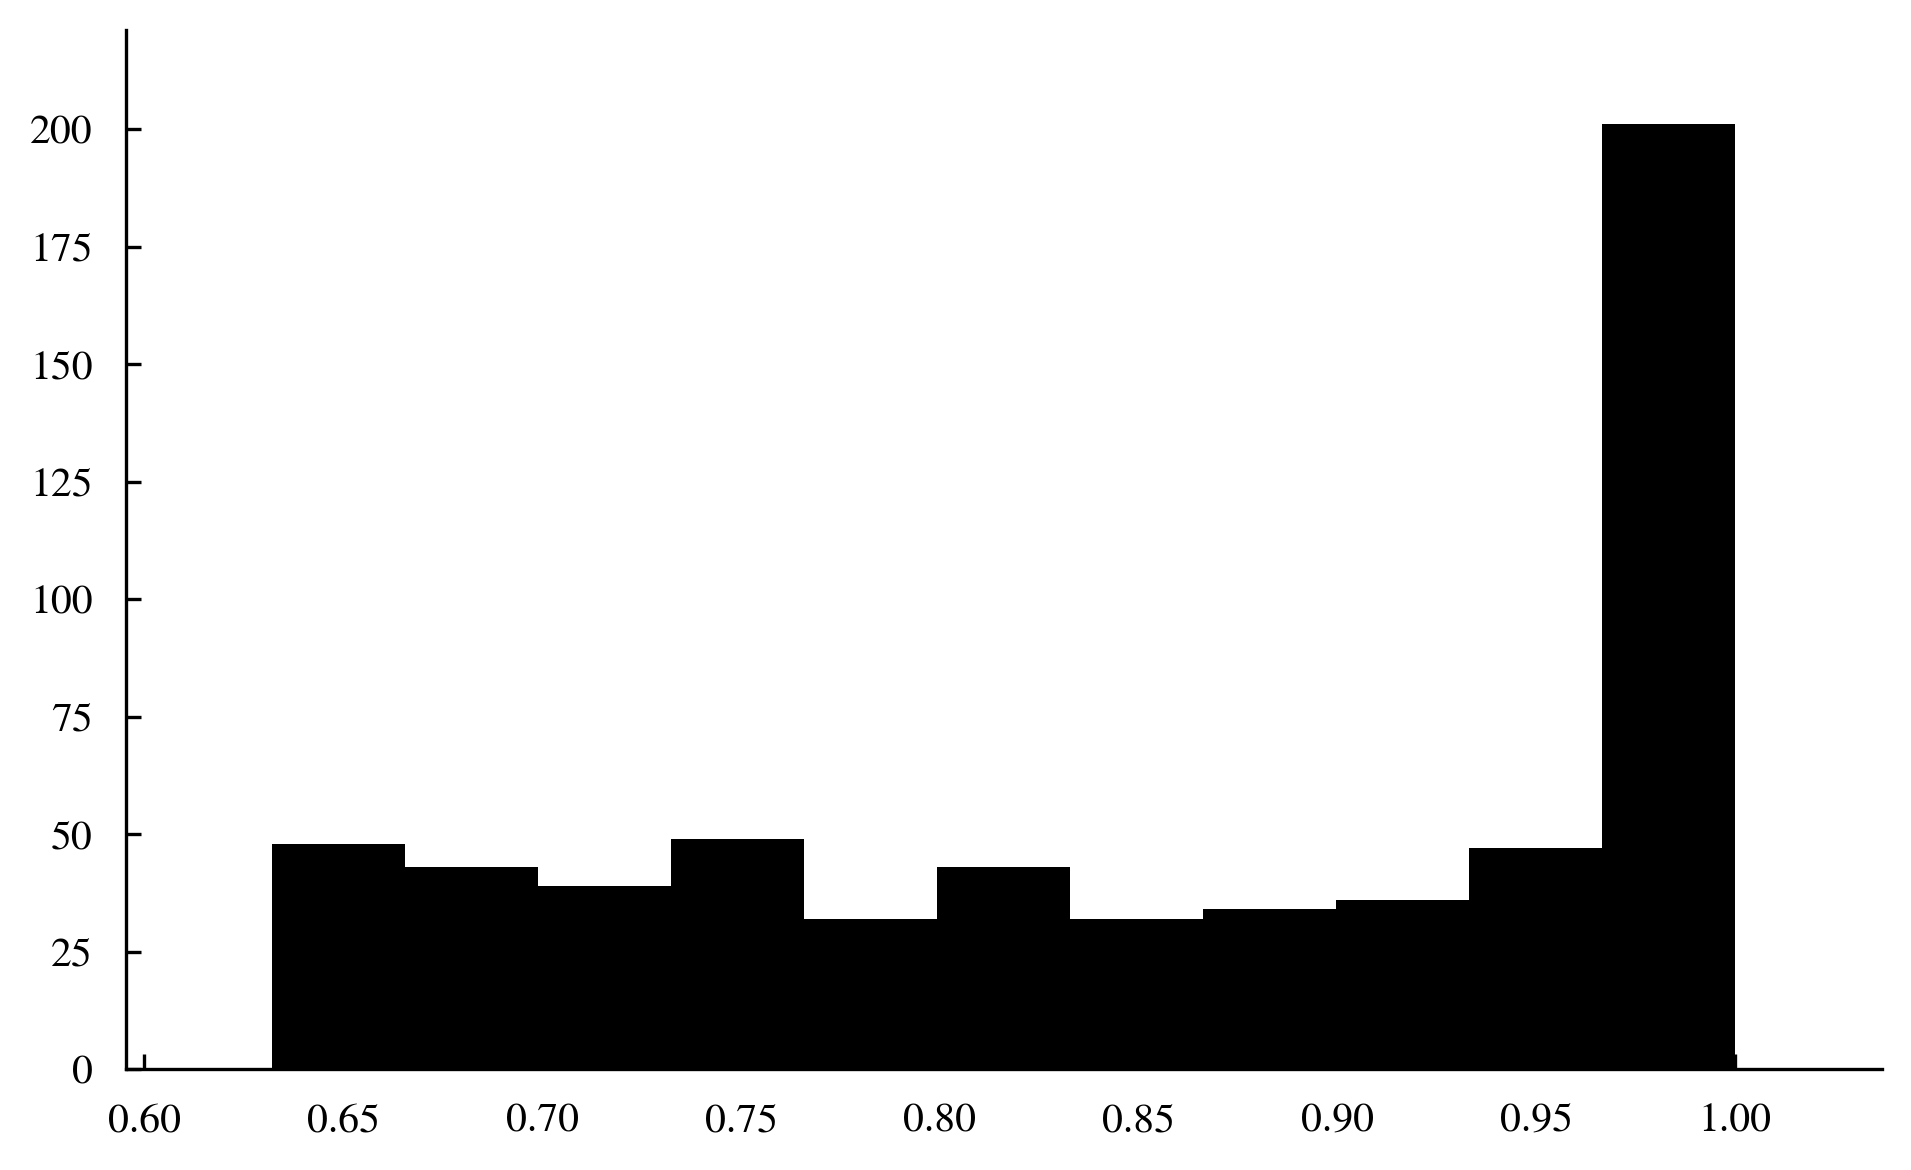

In [45]:
whereBAD = rd.reduced["EXP_CORRECTED_P"] >= 1
plt.hist(rd.reduced[whereBAD * l_n4]["BERNOULLI_P"])

Pandas support in corner is deprecated; use ArviZ directly


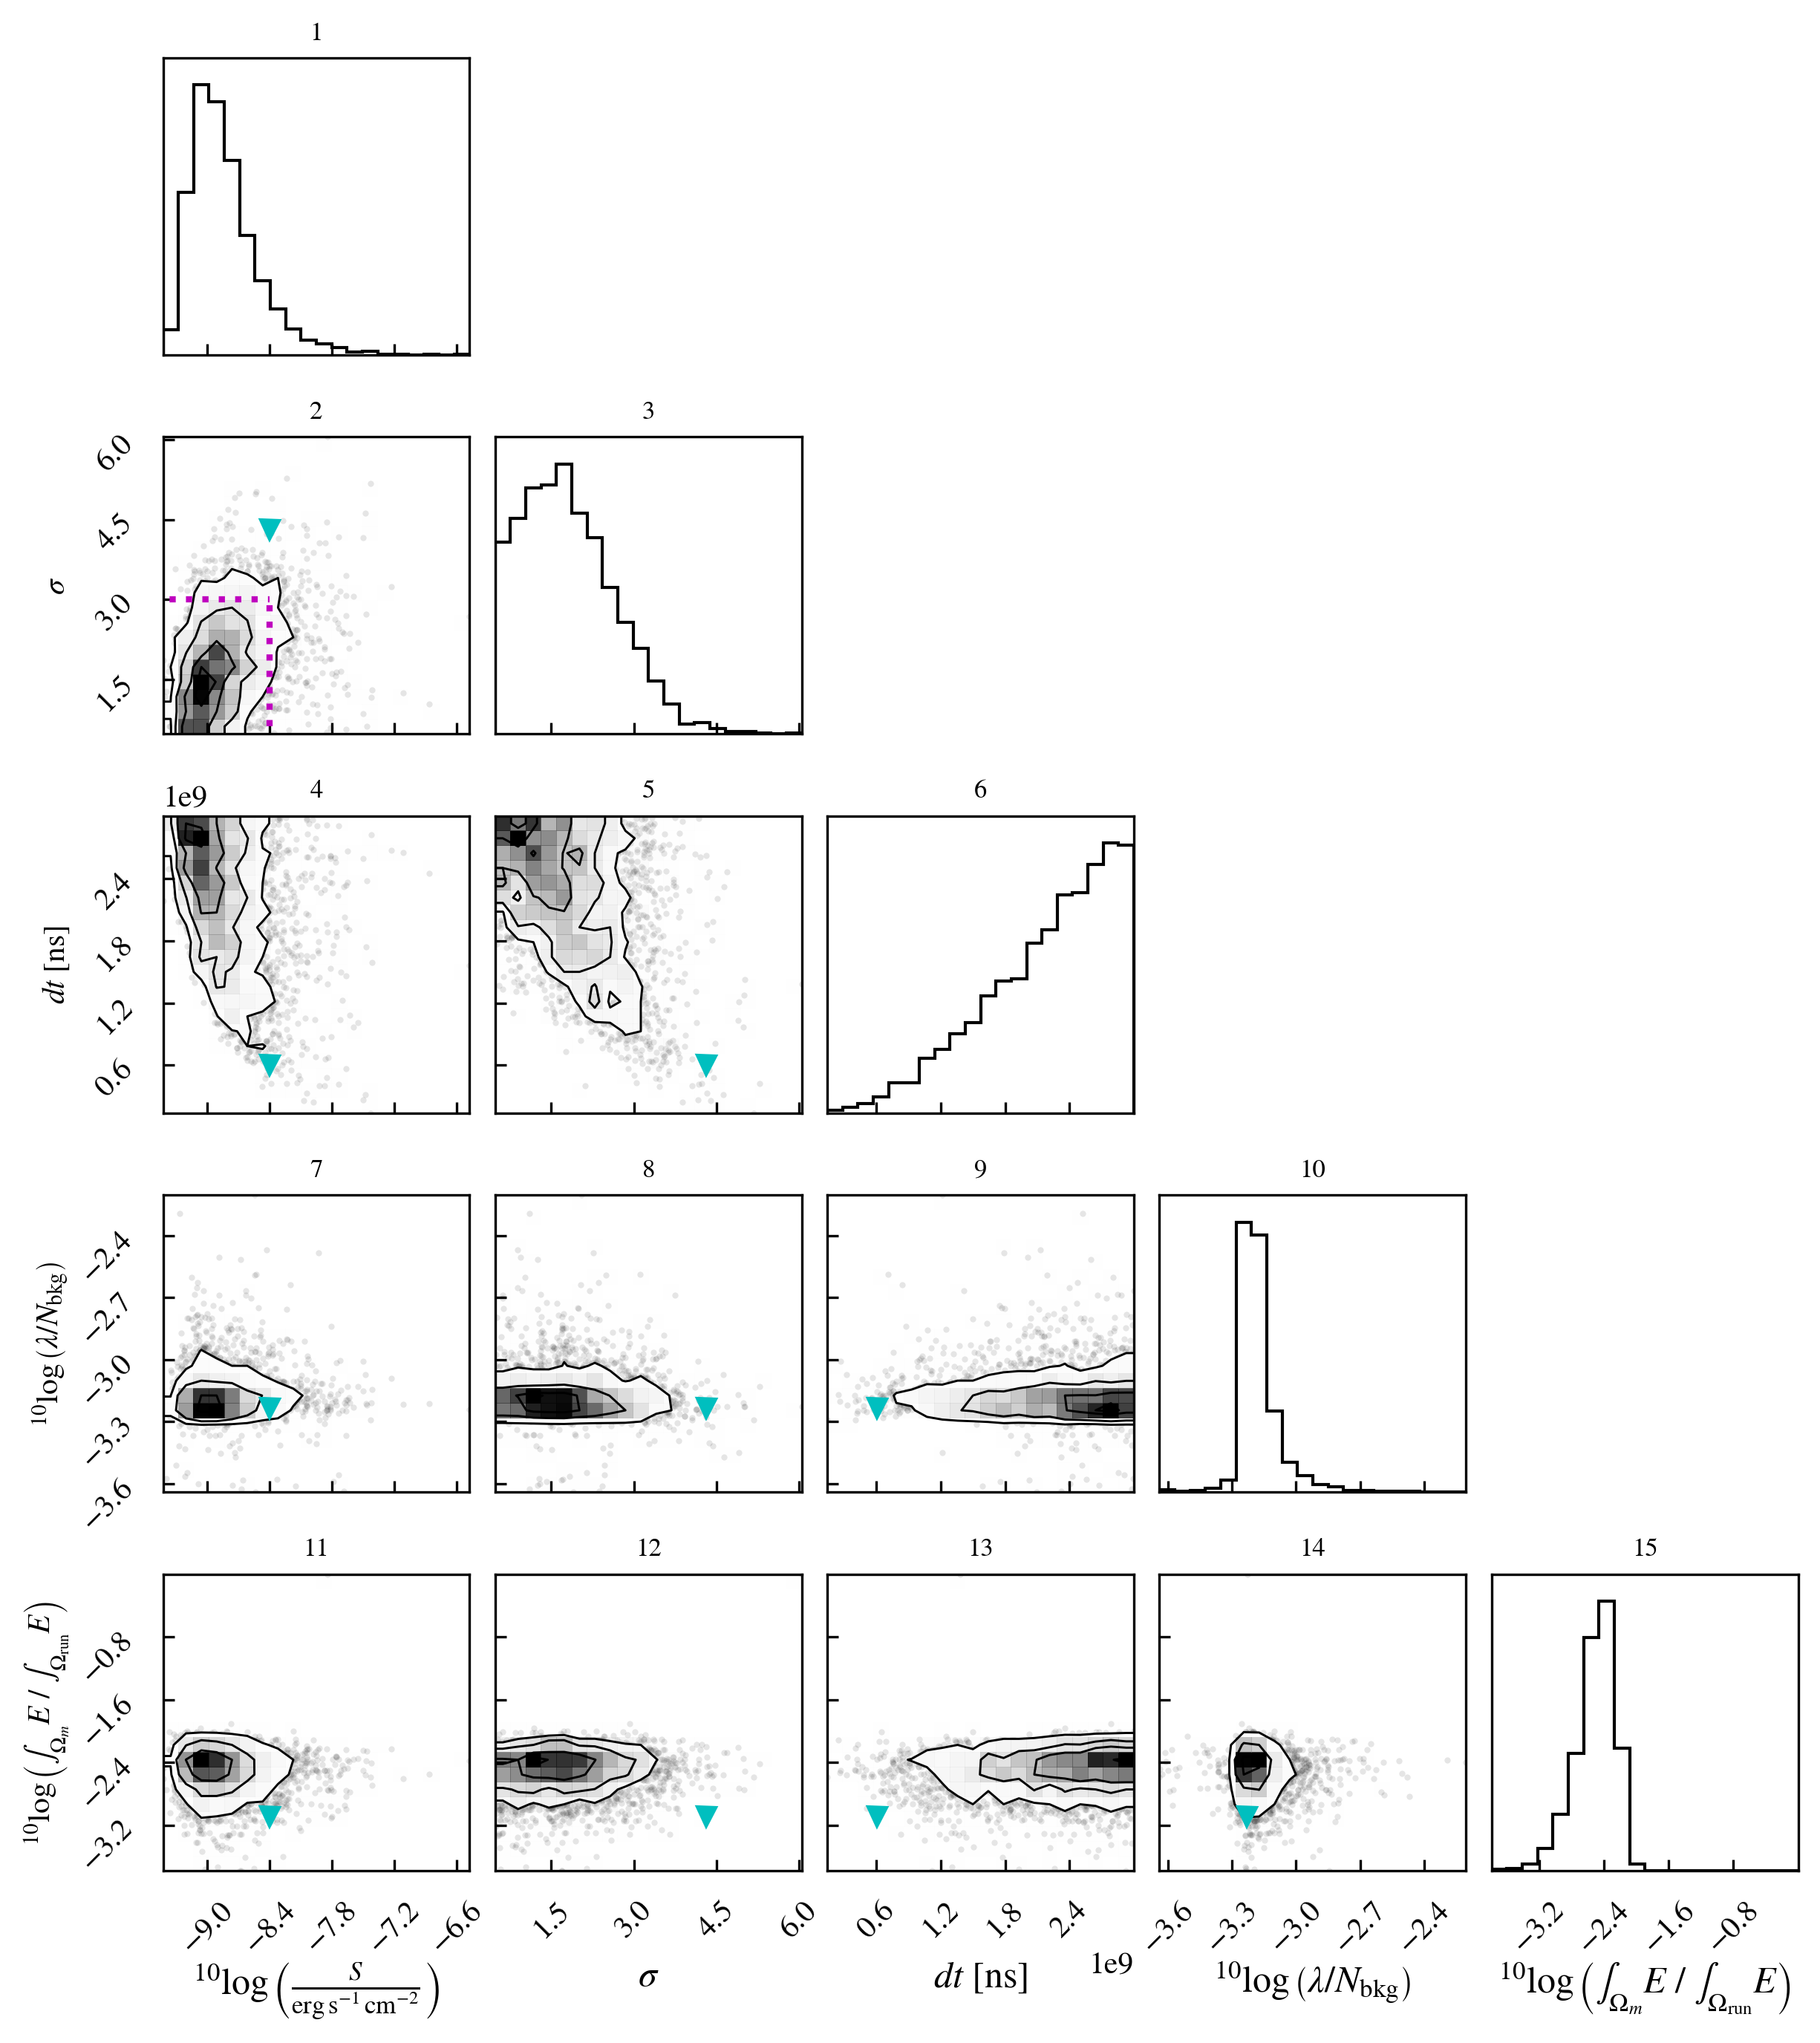

In [48]:
from matplotlib import figure,axes
varnames = ["LOG_FLUX_ERGS_PER_SECOND_CM2","BERNOULLI_SIGMA","dt","LOG_LAMBDA_RATIO","LOG_BELL_FRAC"]
varlabels = [r"$^{10}\log\left(\frac{S}{\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}}\right)$",r"$\sigma$",r"$dt$ [ns]", r"$^{10}\log\left(\lambda / N_\mathrm{bkg}\right)$",r"$^{10}\log\left(\int_{\Omega_m} E~/~\int_{\Omega_\mathrm{run}} E\right)$"]
fig: figure.Figure = corner(rd.reduced[l_n4*~whereBAD].to_pandas(),var_names=varnames,labels=varlabels)
# print(rd.getCandidate(35007)[varnames].to_pandas())
overplot_points(fig, rd.getCandidate(35007)[varnames].to_pandas(),marker='v',color="c")
axs: list[axes.Axes] = fig.get_axes()
for i,ax in enumerate(axs):
    for spine in ["top","right"]:
        ax.spines[spine].set_visible(True)
    # ax.set_title(i)
    ax.set_xlabel(ax.get_xlabel(),fontsize="large")
# axes[0].set_yscale("log")
axs[5].vlines(-8.4,0,3,color="m",ls=":",lw=2)
axs[5].hlines(3,-10,-8.4,color="m",ls=":",lw=2)
# axs[2].text(-8,2,"Short Burst Flux limit\nfor H.E.S.S.?")
for i,j in zip(range(1,16),[0,5,6,10,11,12,15,16,17,18,20,21,22,23,24]):
    axs[j].set_title(i,fontsize="small")
fig.set_size_inches(8,9)
# fig.text(.58,.65,f"Pearson correlation:\n{np.round(get_correlation(rd.reduced[l_n4],var_names=['LOG_FLUX_ERGS_PER_SECOND_CM2','BERNOULLI_SIGMA'])[0],2)}",fontsize="large")

fig.set_tight_layout({"pad":.1})

fig.savefig("figures/n4_larger_corner.png",facecolor='white',dpi=300)

In [ ]:
from matplotlib import figure
fig = figure.Figure(figsize=(5,3))
ax = fig.add_subplot()
ax.hist(rd.reduced[l_n4]['BERNOULLI_SIGMA'],histtype="step")
ax.set_yscale("log")
fig.savefig("figures/n4_sigmahist.png",facecolor="white",dpi=300)

## Fitting log flux to sigma
it doesnt work well

In [ ]:
X = rd.reduced[l_n4]["LOG_FLUX_ERGS_PER_SECOND_CM2"]
Y = rd.reduced[l_n4]["BERNOULLI_SIGMA"]

def linear(x,a,b):
    return a*x + b
def root(x,a,b,c):
    return a*np.sqrt(x-b) + c
def loga(x,a,b,c):
    return a*np.log10(x-b) + c

from scipy.optimize import curve_fit

# p,pcov = curve_fit(linear,X,Y)
# # proot,pcovroot = curve_fit(root,X,Y)
p,pcov = curve_fit(loga,X,Y,p0=(1.,-10,0))

In [ ]:
p,pcov

In [ ]:
pvar = np.diag(pcov)

In [ ]:
fn = loga

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X,Y,s=.1)
xspace = np.linspace(-9.5,-6.5)
yspace = fn(xspace,*p)
yup = fn(xspace,*(p + 2*np.sqrt(pvar)))
ydown = fn(xspace,*(p - 2*np.sqrt(pvar)))
ax.plot(xspace,yspace)
ax.fill_between(xspace,ydown,yup)

## Candidates
Luminosity

In [ ]:
def luminosity(flux:float, distance_cm: float) -> float:
    return flux * 4 * np.pi * distance_cm **2

print("galactica nd extragalactic luminosity estimates in ergs per second of the 35007 mplet")
for d in [3e22, 3e24 *  2863]: #10kpc galactic, 0.5z = 2863 Mpc xgal
    print(luminosity(rd.getCandidate(35007)["FLUX_ERGS_PER_SECOND_CM2"].data,d))

In [ ]:
cand = rd.getCandidate(35007)[0]
toa_bkg = [180828547.77256322, 180828950.41976643, 180829178.5714972, 180829669.495579,180829828.01819682]
toa_sgl = [180829669.5254898, 180829669.78794956, 180829670.10159612]
from scipy.stats import expon
from math import factorial
rate_bkg = 1.0/expon.fit(np.diff(toa_bkg),floc=0.)[1]
rate_sgl = 1.0 / expon.fit(np.diff(toa_sgl),floc=0)[1]

L = 3 * rate_bkg / rate_sgl
sum = 1
for i in range(3):
    sum -= L**i * np.exp(-L) / factorial(i)

p_succes = sum / cand["BELL_FRACTION"]
sign = (1.-(1.-p_succes)**(23490))
print(sc.n_sigmas(sign))
print(cand["BERNOULLI_SIGMA"])


In [ ]:
1688/60

In [ ]:
ds = sc.getDataStores()[0]
obs = ds.obs(35007)
# obs.obs_info

In [ ]:
float(ax.get_xticklabels()[0].get_text())

In [ ]:
cd = rd.getCandidate(35007)
cd = sc.Candidate(cd[cd["BERNOULLI_SIGMA"] > 4])
from matplotlib import figure,axes
obj = cd.ToAScatter(0.1)
fig: figure.Figure = obj[0]
ax: axes.Axes = obj[1]
fig.set_size_inches(5,3)
ax.set_xlabel("ToA from run start [min]")
# ax.set_xticks([])
# ax.ticklabel_format(style="sci",axis="x",useOffset=False)
ax.fill_between(np.linspace(1.8082964*1e8,1.808297*1e8),.025,.07,color="red",alpha=.5,zorder=3)
ax.fill_between(np.linspace(1.8082964*1e8,1.808297*1e8),.025,.105,color="orange",alpha=.4,zorder=3)
fig.text(.55,.4,"Triplet",color="darkred")
fig.text(.55,.3,"Quadruplet",color="darkorange")
ax.set_ylim(0,.11)
ax.set_xlim(min(obs.events.table["TIME"]),max(obs.events.table["TIME"]))
ax.set_yticks([0,.05,.1])
xticks = ax.get_xticks()
xlims = ax.get_xlim()
def hesstime_to_minutes(x,pos):
    fraction = (x - xlims[0])/(xlims[1]-xlims[0])
    return np.round(fraction*1688/60,2)
ax.xaxis.set_major_formatter(hesstime_to_minutes)
ax.set_ylabel(r"$d(\mathrm{phot},\mathrm{mplet})$ [deg]")
fig.savefig("figures/report_ToA_35007.png",facecolor="white",dpi=300)

In [ ]:
sixplets = rd.reduced[rd.reduced["Nmax"] == 6]
sixplets.sort("dt")
sixplets

In [ ]:
cd.mplet["dt"] / 1e6

In [ ]:
significant_table = rd.reduced[rd.reduced["BERNOULLI_SIGMA"] > 5]
significant_table.sort("BERNOULLI_SIGMA")
significant_table

In [ ]:
rd_old.getCandidate(35007)

In [ ]:
plt.figure()
plt.yscale("log")
h = plt.hist(rd.reduced[l_n4]["BERNOULLI_SIGMA"],histtype="step",color="m",bins="fd",label="$da = 0.4$",density=True)
h2 = plt.hist(rd_old.reduced[l_n3]["BERNOULLI_SIGMA"],histtype="step",color="c",bins="fd",label="$da = 0.2$",density=True)
plt.legend()
plt.xlabel("sigma")


In [ ]:
for var,label in zip(["PNT_DISTANCE","ALT_PNT"],[r"$d(\mathrm{mplet}, PNT)$ [deg]",r"Pointing altitude [deg]"]):
    pearson, spearman = pearsonr(rd.reduced[l_n4]["BERNOULLI_SIGMA"].data,rd.reduced[l_n4][var].data)[0],spearmanr(rd.reduced[l_n4]["BERNOULLI_SIGMA"].data,rd.reduced[l_n4][var].data)[0]
    fig = corner(rd.reduced[l_n4].to_pandas(),var_names=[var,"BERNOULLI_SIGMA"],labels=[label,r"$\sigma$"])
    fig.text(.55,.7,f"Pearson correlation: {np.round(pearson,2)}\nSpearman rank correlation: {round(spearman,2)}",fontsize="large")
    fig.set_size_inches(4,4)
    for ax in fig.get_axes():
        ax.spines["right"].set_visible(True)
        ax.spines["top"].set_visible(True)
    plt.savefig("figures/combined/pnt-significance-correlation.png",facecolor="white",dpi=300)